In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models

In [2]:
# RUN THIS CELL TO DOWNLOAD DATASET 

# to download dataset
!wget  -q /content/train.zip
!wget  -q /content/val.zip

In [3]:
# # to unzip dataset 
!unzip -q train.zip -d content/
!unzip -q val.zip -d content/

In [4]:
def plot_loss_accuracy(history):
    '''
    A function to plot train and validation loss against epochs of training
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [5]:
# using ImageDataGenerator to load data from the disk
# TODO : try if inverting white and black in dataset images has any effect on the performance of the model

train_data_path = 'content/train'
val_data_path = 'content/val'

IMAGE_SIZE = 32
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1) # 3 channels
NUM_OF_CLASSES = 10

train_image_generator = ImageDataGenerator( rescale=1./255 )
val_image_generator = ImageDataGenerator( rescale=1./255 )

train_data_gen = train_image_generator.flow_from_directory(
    train_data_path, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    color_mode='grayscale', # for 1 channel images
    class_mode='sparse', # labels will be integers
    batch_size=32, 
    shuffle=True, 
    seed=None,
    )

val_data_gen = val_image_generator.flow_from_directory(
    val_data_path, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    color_mode='grayscale', # for 1 channel images
    class_mode='sparse', # labels will be integers
    batch_size=32, 
    shuffle=True, 
    seed=None,
    )

Found 1000 images belonging to 10 classes.
Found 178 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:202: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


shape of a batch given by image data generator : (32, 32, 32)


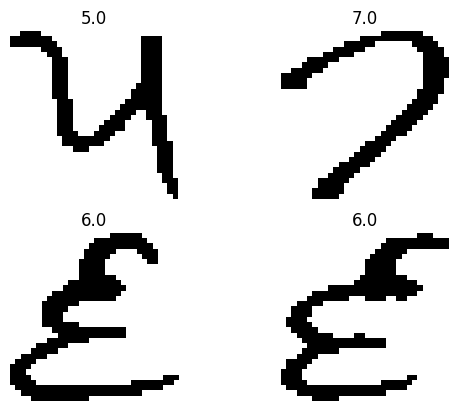

In [6]:
# checking/ validating some images generated by datagenerator

# This function will plot 4 images along with their labels.
def plotImages(image_datas,y_list):
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(image_datas[0], cmap='gray')
    axarr[0,0].set_title(y_list[0])
    axarr[0,0].axis('off')
    axarr[0,1].imshow(image_datas[1], cmap='gray')
    axarr[0,1].set_title(y_list[1])
    axarr[0,1].axis('off')
    axarr[1,0].imshow(image_datas[2], cmap='gray')
    axarr[1,0].set_title(y_list[2])
    axarr[1,0].axis('off')
    axarr[1,1].imshow(image_datas[3], cmap='gray')
    axarr[1,1].set_title(y_list[3])
    axarr[1,1].axis('off')

sample_training_images, y_list = next(train_data_gen)
sample_training_images = np.squeeze(sample_training_images) # to reduce dimension
print("shape of a batch given by image data generator : {}".format(sample_training_images.shape))

plotImages(sample_training_images[:4],y_list[:4])

In [7]:
# Trying a simple 1 layer NN : to get a baseline 
# TODO : make some variables to define learning rate, optimizer, etc. 

def create_1_layer_NN():
    model = tf.keras.models.Sequential([
        layers.Flatten(input_shape = IMAGE_SHAPE),
        layers.Dense(NUM_OF_CLASSES, activation='softmax') 
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [8]:
one_layer_NN_model = create_1_layer_NN()
one_layer_NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 10,250
Trainable params: 10,250
Non-trainable params: 0
_________________________________________________________________


In [9]:
one_layer_NN_checkpoint_filepath = 'one_layer_NN/checkpoint/'
one_layer_NN_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=one_layer_NN_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

one_layer_NN_model_history = one_layer_NN_model.fit(train_data_gen, epochs=80, 
                    validation_data=val_data_gen,
                    callbacks=[one_layer_NN_checkpoint_callback])

Epoch 1/80
32/32 [==============================] - 1s 24ms/step - loss: 1.4511 - accuracy: 0.5850 - val_loss: 0.9613 - val_accuracy: 0.7640
Epoch 2/80
32/32 [==============================] - 1s 16ms/step - loss: 0.5363 - accuracy: 0.8840 - val_loss: 0.6116 - val_accuracy: 0.8764
Epoch 3/80
32/32 [==============================] - 1s 16ms/step - loss: 0.3352 - accuracy: 0.9300 - val_loss: 0.4939 - val_accuracy: 0.8876
Epoch 4/80
32/32 [==============================] - 1s 17ms/step - loss: 0.2526 - accuracy: 0.9490 - val_loss: 0.4071 - val_accuracy: 0.9045
Epoch 5/80
32/32 [==============================] - 1s 16ms/step - loss: 0.2094 - accuracy: 0.9560 - val_loss: 0.3534 - val_accuracy: 0.9213
Epoch 6/80
32/32 [==============================] - 1s 16ms/step - loss: 0.1722 - accuracy: 0.9670 - val_loss: 0.3170 - val_accuracy: 0.9382
Epoch 7/80
32/32 [==============================] - 1s 16ms/step - loss: 0.1547 - accuracy: 0.9720 - val_loss: 0.2882 - val_accuracy: 0.9438
Epoch 8/80
32

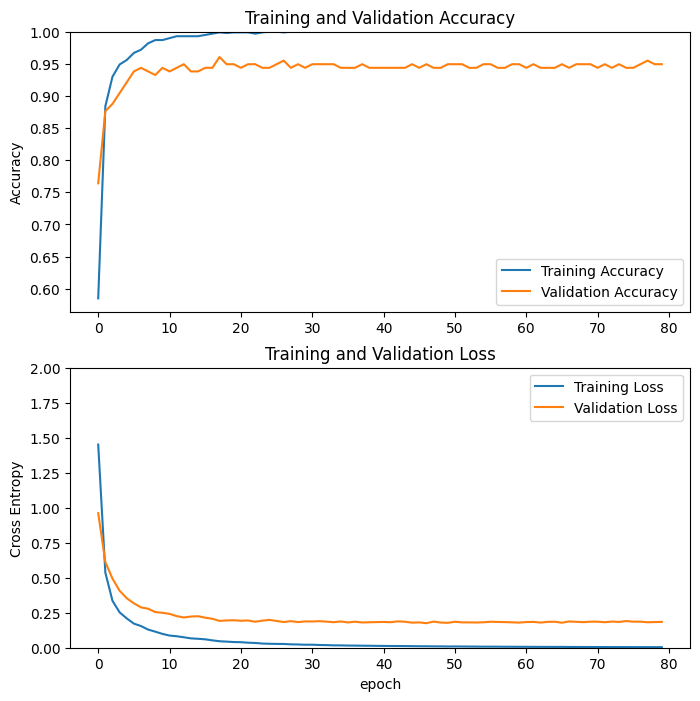

In [10]:
plot_loss_accuracy(one_layer_NN_model_history)